# A TensorFlow demo

Auteur : Alexandre Gramfort


Doc at : http://www.tensorflow.org

In [2]:
%matplotlib inline                      

import numpy as np                      # charge un package pour le numérique
import matplotlib.pyplot as plt         # charge un package pour les graphiques

import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction à TensorFlow

TensorFlow est un système de calcul basé sur des graphes exprimés de façon symbolique.
Cele permet d'utiliser de la différenciation automatique et d'apprendre les paramètres par des méthodes de type descente de gradient.

- https://www.tensorflow.org 

Objets dans TensorFlow:
- **constant:** tenseurs constant, tels que le learning rate
- **Variables:** n'importe quel tenseur, tels que les parametètres des modèles
- **Placeholders:** placeholders pour les entrées et les sorties des modèles
- et beaucoup d'autres (functions, loss, ...)

Le graphe est symbolique. Aucun calcul est effectué jusqu'à qu'une `Session` soit définie et lancée avec `run` ou `eval`. TensorFlow peut effectuer le calcul sur (plusieurs) CPUs ou GPUs.

In [3]:
import tensorflow as tf

a = tf.constant(3)
b = tf.constant(2)
c = a + b

In [4]:
print(type(a))
print(a)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Const:0", shape=(), dtype=int32)


In [5]:
print(type(c))
print(c)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add:0", shape=(), dtype=int32)


In [6]:
with tf.Session() as sess:
    c_value = sess.run(c)
    
print(type(c_value))
print(c_value)

<class 'numpy.int32'>
5


#### placeholders

- Un placeholder est une variable qui n'a pas encore de valeur dans le graphe symbolique. La valeur sera assignée lors de la commande `run` avec le paramètre `feed_dict`.
- Si le placeholder est un tensor à k-dimensions, il est nécessaire de préciser sa taille `shape`. 
- Il est possible de laisser la shape variable en mettant `None` comme valeur dans la shape.

In [7]:
x = tf.placeholder("float32", name="input")
y = x + tf.constant(3.0)

with tf.Session() as sess:
    print(sess.run(y, feed_dict={x: 2}))

5.0


Et sans préciser les tailles

In [8]:
img = tf.placeholder("float32", shape=[None, None, 1], name="input")
inverted_image = 255. - img
with tf.Session() as sess:
    fake_img = np.zeros(shape=(3, 2, 1))
    print(sess.run(inverted_image, feed_dict={img:fake_img}))

[[[255.]
  [255.]]

 [[255.]
  [255.]]

 [[255.]
  [255.]]]


### Calcul de gradients automatiques

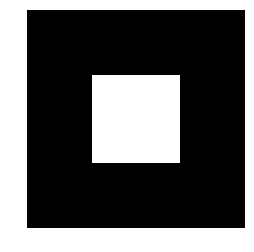

In [9]:
from scipy.misc import face

img_demo = np.zeros((100, 100))
img_demo[30:70, 30:70] = 1.

plt.imshow(img_demo, cmap=plt.cm.gray)
plt.axis('off');

On va définir la fonction qui renvoie la somme des écarts au carré à 1 pour chaque pixel.
On va ensuite utiliser la différenciation automatique de TensorFlow.

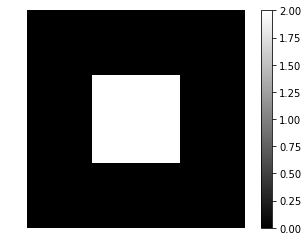

In [10]:
grads = tf.gradients(tf.reduce_sum(img ** 2), img)

with tf.Session() as sess:
    img_grads, = sess.run(grads, feed_dict={img: img_demo[:, :, np.newaxis]})

plt.imshow(np.abs(np.sum(img_grads, axis=2)), cmap=plt.cm.gray)
plt.axis('off')
plt.colorbar();

### Question:

   - Retrouver le résultat analytiquement.

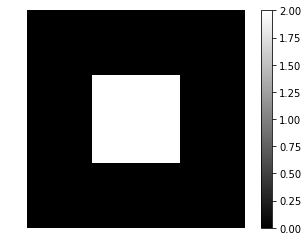

In [11]:
np_img_grads = 2. * img_demo
plt.imshow(np_img_grads, cmap=plt.cm.gray)
plt.axis('off')
plt.colorbar();

## Regression logistique

In [12]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# Make it binary
X = X[y < 2]
y = y[y < 2]

# add intercept column of ones
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

y[y == 0] = -1

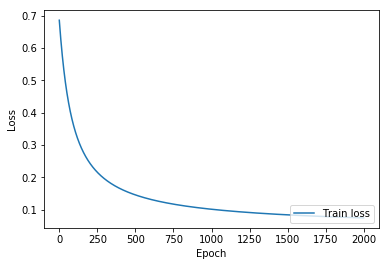

In [13]:
n_samples, n_features = X.shape

# tf Graph Input
X_input = tf.placeholder(tf.float32, [None, n_features])
y_input = tf.placeholder(tf.float32, [None, 1])

# Set model parameters
w = tf.Variable(tf.zeros([n_features, 1]))

# Construct loss for each sample
loss = tf.log(1. + tf.exp(- y_input * tf.matmul(X_input, w)))

# Minimize the average loss
cost = tf.reduce_mean(loss)

# Gradient Descent + parameters
n_iterations = 2000
train_accuracy = []
test_accuracy = []
learning_rate = .1
train_loss = []

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_iterations):
        sess.run(optimizer, feed_dict={X_input: X, y_input: y[:, None]})
        
        w_array = w.eval(sess)

        train_loss.append(sess.run(cost, feed_dict={X_input: X, y_input: y[:, None]}))

    sess.close()

plt.figure()
plt.plot(train_loss, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right');

### Let's look at the result

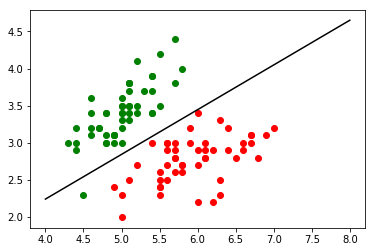

In [14]:
plt.scatter(X[y > 0, 0], X[y > 0, 1], color='r')
plt.scatter(X[y < 0, 0], X[y < 0, 1], color='g')
xx = np.linspace(4, 8, 10)
plt.plot(xx,  - xx * w_array[0] / w_array[1] - w_array[2] / w_array[1], 'k');